In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [3]:
np.random.seed(0)

# 2.a.1. Draw Exercise Boundary for American Put Option

In [4]:
# basic 
T = 1
S0 = 10
mu = 0.05
sigma = 0.2
r = 0.02
Ntrials = 5000
# Ntrials = 100
K = 10


### Using B as a numeraire 

In [5]:
timeStep = T / Ntrials
u = np.exp(r * timeStep + sigma * np.sqrt(timeStep))  # one step under P 
d = np.exp(r * timeStep - sigma * np.sqrt(timeStep))  # one step under P
# risk neutral probability
Qu = 0.5 * (1 - 0.5 * sigma * np.sqrt(timeStep))  # see answers in Q1
Qd = 1 - Qu

In [6]:
# asset tree
asset_tree = np.full((Ntrials + 1, Ntrials + 1), np.nan)
# initiate with current price
asset_tree[0, 0] = S0
for i in range(1, Ntrials + 1):
    # we only use the top diagonal of the tree
    asset_tree[0:i, i] = asset_tree[0:i, i - 1] * u
    asset_tree[i, i] = asset_tree[i - 1, i - 1] * d

In [7]:
# calculate the option value 

In [8]:
Q_option_tree = np.full((Ntrials + 1, Ntrials + 1), np.nan)
Q_option_tree[:, -1] = np.maximum(K - asset_tree[:, -1], 0)
for i in range(Ntrials - 1, -1, -1):
    previous_numeraire = np.exp(r * (i + 1) / Ntrials)
    current_numeraire = np.exp(r * i / Ntrials)
    Q_option_tree[0:i + 1, i] = (Qu * Q_option_tree[0:i + 1, i + 1] / previous_numeraire + Qd * Q_option_tree[1:i + 2,
                                                                                                i + 1] / previous_numeraire) * current_numeraire
    # # because this is an american option, we consider the early exercise possibility
    Q_option_tree[0:i + 1, i] = np.maximum(K - asset_tree[0:i + 1, i], Q_option_tree[0:i + 1, i])


In [9]:
def np_groupby(data, key):
    unique_keys = np.unique(key)
    grouped_data = {unique_key: [] for unique_key in unique_keys}
    for i in range(len(data)):
        grouped_data[key[i]].append(data[i])
    return grouped_data


grouped_timestamp = np_groupby(*np.where((K - asset_tree - Q_option_tree) == 0))

In [10]:
grouped_timestamp = np.vstack([[min(item) for item in grouped_timestamp.values()], list(grouped_timestamp.keys())])

In [11]:
execution_boundary = asset_tree[grouped_timestamp[0], grouped_timestamp[1]]

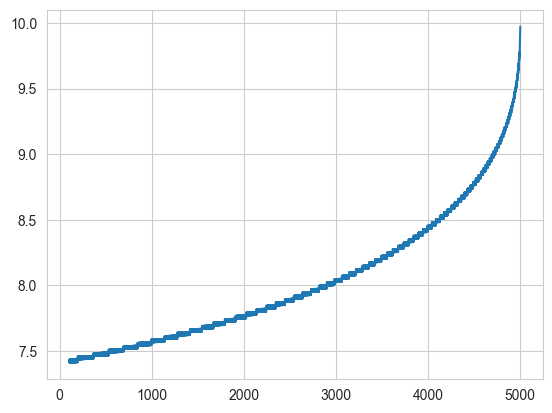

In [12]:
plt.plot(grouped_timestamp[1], execution_boundary)

### Path simulation

In [13]:
T = 1
S0 = 10
K = 10
mu = 0.05
sigma = 0.2
r = 0.02
N = 5000


In [14]:
def sample_path(S0, T, N, r, mu, sigma):
    timeStep = T / N
    prob_epsilon_up = 0.5 * (1 + ((mu - r) - 0.5 * sigma ** 2) / sigma * np.sqrt(timeStep))
    Ntrials = 10_000
    total_path = np.empty((Ntrials, N + 1))
    total_path[:, 0] = S0
    for i in range(N):
        U = np.random.rand(Ntrials)
        epsilon = 1 * (U < prob_epsilon_up) + (-1) * (U >= prob_epsilon_up)  # realization of epsilon
        total_path[:, i + 1] = total_path[:, i] * np.exp(r * timeStep + sigma * np.sqrt(timeStep) * epsilon)
    return total_path

In [15]:
total_path = sample_path(S0, T, N, r, mu, sigma)

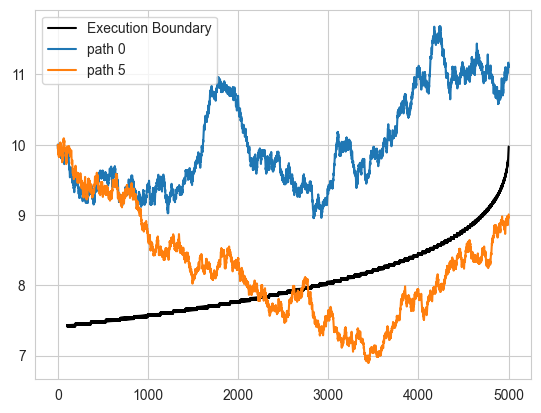

In [63]:
plt.plot(grouped_timestamp[1], execution_boundary, label='Execution Boundary',color='black')
for i in range(10):
    if i ==5 or i==0:
        plt.plot(total_path[i, :].T,label=f'path {i}')
plt.legend()


In [38]:
execution_boundary[0]

7.433674197374958

### Option Hedge Strategy

In [17]:
asset_tree.shape

(5001, 5001)

In [219]:
alpha = []
beta = []
for idx,price in enumerate(total_path[5,:-1]):
    # time = idx+1
    time = idx
    location = np.where(np.abs(price - asset_tree[:,time])<0.0001)[0][0]# the tolerance is because memory accuracy
    option_up = Q_option_tree[location,time+1]
    option_down = Q_option_tree[location+1,time+1]
    asset_price_up = asset_tree[location,time+1]
    asset_price_down = asset_tree[location+1,time+1]
    alpha_i = (option_up-option_down)/(asset_price_up-asset_price_down)
    B = np.exp(r*((time+1)/Ntrials))
    beta_i = (option_up-alpha_i*asset_price_up)/np.exp(r*(time/Ntrials))
    alpha.append(alpha_i)
    beta.append(beta_i)
    

In [220]:
option_price_path = []
for time,price in enumerate(total_path[5,:]):
    location = np.where(np.abs(price - asset_tree[:,time])<0.0001)[0]# the tolerance is because memory accuracy
    option_price_path.append(Q_option_tree[location,time][0])

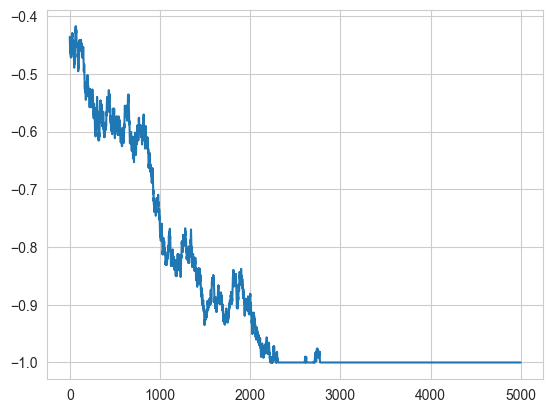

In [222]:
plt.plot(alpha)

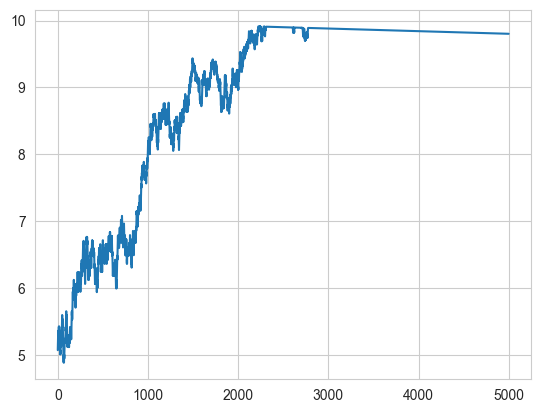

In [223]:
plt.plot(beta)

In [225]:
len(alpha)

5000

In [226]:
len(beta)

5000

In [227]:
hedge_portfolio = np.array(alpha)*total_path[5,:-1]+np.array(beta)*np.exp(r*np.arange(0,1,1/Ntrials))

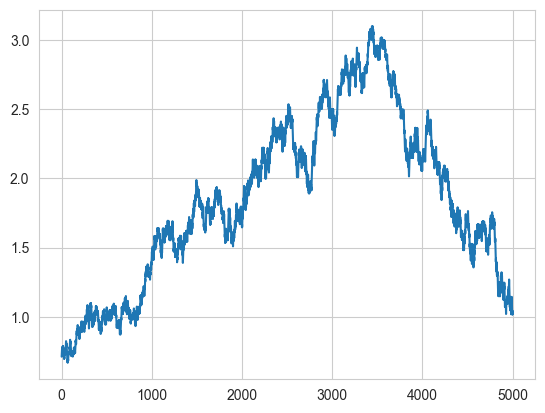

In [228]:
plt.plot(hedge_portfolio)

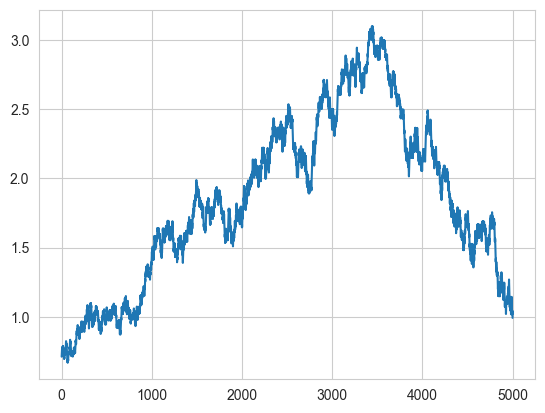

In [229]:
plt.plot(option_price_path)